# Intake

In [1]:
import numpy as np
import glob          #  Unix style pathname pattern expansion
import os            #  Operating system
import sys           #  system specific 
import pickle          
import subprocess
import intake
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # For progress bar
from cdo import Cdo   # Climate Data operator 
cdo = Cdo()           # object to use CDO in python

sys.path.insert(0, '/home/u/u301557/UHH-CMIP6/scripts/functions')
import STOR_CMIP6
import pandas as pd

print("DONE")

DONE


In [2]:
col_url = "/work/ik1017/Catalogs/dkrz_cmip6_disk.json"
col = intake.open_esm_datastore(col_url)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/intake_esm/cat.py:264: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [3]:
DF = []
variables = ["fgco2", "nbp", "fLuc", "npp", "gpp", "rh","ra", "cVeg", "cSoil", "cLitter"]

for scenario in ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]:

    if scenario == "historical":
        activity = 'CMIP'
    else:
        activity = 'ScenarioMIP'
    
     # search the catalog
    query      = dict(activity_id=activity, variable_id= variables, experiment_id=scenario)
    col_subset = col.search(**query)
    
    # create dataframe from search
    df_init     = col_subset.df
    df_overview = df_init.copy()
    df_overview = df_overview.groupby([ 'source_id','variable_id']).member_id.aggregate('nunique').unstack()
    
    # list variables without data for each model
    df_overview[scenario] = df_overview.loc[df_overview.index].isna().apply(lambda row: row[row].index.tolist(), axis=1)
    
    DF.append(pd.DataFrame(df_overview[scenario]))

In [4]:
limit=10

# Start with the first DataFrame
merged_df = DF[0]

# Merge the rest of the DataFrames
for df in DF[1:]:
    merged_df = merged_df.join(df, how='outer')
merged_df = merged_df.fillna(len(variables))

def map(val):
    try:
        description = ""
        if len(val) == 0:
            description = "all"
        elif len(val) < limit:
            description = str(val)
        else:
            description = "missing"
        
    except:
        description = "none"

    return description
        

for column in merged_df.columns:
    merged_df[column] = [map(x) for x in merged_df[column]]
    
#merged_df

In [5]:
styles = [dict(selector="th", props=[('width', '60px')]),
          dict(selector="th.col_heading",
               props=[('transform', 'rotateZ(-90deg)',), 
                      ('max-height', '180px'),
                      ('height', '160px'),
                      ('max-width', '5px'),
                      ('vertical-align', 'left')])]

def highlight_color(val):
    """Helper function to highlight all non-NaN values."""
    #color = 'rgba(0,255,50,.2)' if not np.isnan(val) else ''
    if val == "all":
        color = 'rgba(0,255,50)'
    elif val == "none":
        color='rgba(0,0,0)'
    elif val == "missing" :
        color= 'rgba(255,0,0)'
    else:
        color='rgba(255,165,0)'
    return 'background-color: {}'.format(color)


d_ = merged_df.copy()
#d_.columns = d_.columns.str.replace('-', '&#8209;')   # this is only cosmetics to avoid line-breaks at hyphens in the heading
#cm = sns.light_palette("green", as_cmap=True)
d_styled = (d_
    .style
    .applymap(highlight_color)
    .format(None, na_rep="",precision=0)
    #.set_precision(0)
    .set_table_styles(styles)
    .set_properties(**{'border-color': 'grey', 'border-style' :'dotted', 'border-width':'thin'})
    #.format(desc)
)
d_styled

,historical,ssp126,ssp245,ssp370,ssp585
source_id,,,,,
ACCESS-ESM1-5,['fLuc'],"['cLitter', 'cSoil', 'cVeg', 'fLuc', 'nbp', 'npp', 'ra', 'rh']",['fLuc'],['fLuc'],"['cLitter', 'cSoil', 'cVeg', 'fLuc', 'nbp', 'npp', 'ra', 'rh']"
AWI-ESM-1-1-LR,"['fgco2', 'nbp', 'rh']",none,none,none,none
AWI-ESM-1-REcoM,"['fgco2', 'nbp', 'rh']","['fgco2', 'nbp', 'rh']","['fgco2', 'nbp', 'rh']",none,"['fgco2', 'nbp', 'rh']"
BCC-CSM2-MR,"['fLuc', 'nbp']","['fLuc', 'nbp']","['fLuc', 'nbp']","['fLuc', 'nbp']","['fLuc', 'nbp']"
BCC-ESM1,"['fLuc', 'nbp']",none,none,none,none
CESM2,all,"['cLitter', 'cSoil', 'cVeg', 'fLuc', 'nbp', 'npp', 'ra', 'rh']","['cLitter', 'cSoil', 'fLuc', 'npp', 'rh']","['cLitter', 'cSoil', 'cVeg', 'fLuc', 'nbp', 'npp', 'rh']","['cLitter', 'cSoil', 'cVeg', 'fLuc', 'nbp', 'npp', 'ra', 'rh']"
CESM2-FV2,all,none,none,none,none
CESM2-WACCM,all,"['cLitter', 'cSoil', 'cVeg', 'fLuc', 'npp', 'ra', 'rh']",all,all,all
CESM2-WACCM-FV2,all,none,none,none,none


In [8]:

# Query for historical experiment
query_historical = dict(activity_id="CMIP", variable_id=gridvars, experiment_id="historical")
col_subset_historical = col.search(**query_historical)
df_historical = col_subset_historical.df

# Query for SSP126 experiment
query_ssp126 = dict(activity_id="ScenarioMIP", variable_id=gridvars, experiment_id="ssp126")
col_subset_ssp126 = col.search(**query_ssp126)
df_ssp126 = col_subset_ssp126.df

# Find the common source_ids
historical_models = set(df_historical['source_id'])
ssp126_models = set(df_ssp126['source_id'])
common_models = historical_models.intersection(ssp126_models)

# Create an overview dataframe for the common models
df_common_historical = df_historical[df_historical['source_id'].isin(common_models)]
df_common_ssp126 = df_ssp126[df_ssp126['source_id'].isin(common_models)]

# Aggregate results for both experiments
overview_historical = df_common_historical.groupby(['source_id', 'variable_id']).member_id.aggregate('nunique').unstack()
overview_ssp126 = df_common_ssp126.groupby(['source_id', 'variable_id']).member_id.aggregate('nunique').unstack()

# Stylize the output table for historical models
def highlight_nonNaN(val):
    """Helper function to highlight all non-NaN values."""
    color = 'rgba(0,255,50,.2)' if not np.isnan(val) else ''
    return 'background-color: {}'.format(color)

styles = [dict(selector="th", props=[('width', '60px')]),
          dict(selector="th.col_heading",
               props=[('transform', 'rotateZ(-90deg)',), 
                      ('max-height', '180px'),
                      ('height', '160px'),
                      ('max-width', '5px'),
                      ('vertical-align', 'left')])]

# Stylize the overview tables
overview_styled_historical = (overview_historical
    .style
    .applymap(highlight_nonNaN)
    .format(None, na_rep="", precision=0)
    .set_table_styles(styles)
    .set_properties(**{'border-color': 'grey', 'border-style': 'dotted', 'border-width': 'thin'})
)

overview_styled_ssp126 = (overview_ssp126
    .style
    .applymap(highlight_nonNaN)
    .format(None, na_rep="", precision=0)
    .set_table_styles(styles)
    .set_properties(**{'border-color': 'grey', 'border-style': 'dotted', 'border-width': 'thin'})
)

# Display both styled tables
overview_styled_historical

variable_id,cLitter,cSoil,cVeg,fLuc,fgco2,nbp,npp,ra,rh
source_id,,,,,,,,,
ACCESS-ESM1-5,3,3,9,,20,19,3,9,9
AWI-ESM-1-REcoM,1,1,1,1,,,1,1,
BCC-CSM2-MR,3,3,3,,3,,3,3,3
CESM2,11,11,11,10,11,11,10,11,11
CESM2-WACCM,3,3,3,3,3,3,3,3,3
CMCC-CM2-SR5,,,1,,,1,,1,1
CNRM-CM6-1,,,,,,,18,19,
CNRM-CM6-1-HR,,,,,,,1,1,
CNRM-ESM2-1,9,9,9,9,11,10,9,9,9


In [10]:
common_models 

{'ACCESS-ESM1-5',
 'AWI-ESM-1-REcoM',
 'BCC-CSM2-MR',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'EC-Earth3-Veg',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'NorESM2-MM',
 'UKESM1-0-LL'}

In [5]:
gridvars = ["fgco2", "nbp", "fLuc", "npp", "rh","ra", "cVeg", "cSoil", "cLitter"]
#if cmip == "CMIP6": 
query = dict(activity_id="ScenarioMIP",#['CMIP', 'ScenarioMIP'],
             variable_id= gridvars, experiment_id="ssp126")

col_subset = col.search(**query)
# create dataframe from search
df_init     = col_subset.df
df_overview = df_init.copy()
df_overview = df_overview.groupby([ 'source_id','variable_id']).member_id.aggregate('nunique').unstack()

def highlight_nonNaN(val):
    """Helper function to highlight all non-NaN values."""
    color = 'rgba(0,255,50,.2)' if not np.isnan(val) else ''
    return 'background-color: {}'.format(color)

# stylize the table below
styles = [dict(selector="th", props=[('width', '60px')]),
          dict(selector="th.col_heading",
               props=[#("writing-mode", "vertical-rl"),
                      ('transform', 'rotateZ(-90deg)', ), 
                      ('max-height', '180px'),
                      ('height', '160px'),
                      ('max-width', '5px'),
                      #('text-align', 'bottom'),
                      ('vertical-align', 'left')
                     ])]
d_ = df_overview.copy()
d_.columns = d_.columns.str.replace('-', '&#8209;')   # this is only cosmetics to avoid line-breaks at hyphens in the heading
cm = sns.light_palette("green", as_cmap=True)
d_styled = (d_
    .style
    .applymap(highlight_nonNaN)
    .format(None, na_rep="",precision=0)
    #.set_precision(0)
    .set_table_styles(styles)
    .set_properties(**{'border-color': 'grey', 'border-style' :'dotted', 'border-width':'thin'})
)
d_styled


variable_id,cLitter,cSoil,cVeg,fLuc,fgco2,nbp,npp,ra,rh
source_id,,,,,,,,,
ACCESS-ESM1-5,,,,,1,,,,
AWI-ESM-1-REcoM,1,1,1,1,,,1,1,
BCC-CSM2-MR,1,1,1,,1,,1,1,1
CESM2,,,,,1,,,,
CESM2-WACCM,,,,,1,1,,,
CMCC-CM2-SR5,,,1,,,1,,1,1
CNRM-CM6-1,,,,,,,6,6,
CNRM-CM6-1-HR,,,,,,,1,,
CNRM-ESM2-1,5,5,5,5,5,5,5,5,5


In [2]:
import intake
col = intake.open_esm_datastore("/work/ik1017/Catalogs/dkrz_cmip6_disk.json")
col.df.head()

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/intake_esm/cat.py:264: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,...,frequency,time_reduction,long_name,units,realm,level_type,time_min,time_max,format,uri
0,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c2h6,gn,NaN,v20200511,...,mon,mean,C2H6 Volume Mixing Ratio,mol mol-1,aerosol,alevel,185001.0,201412,netcdf,/work/ik1017/CMIP6/data/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c2h6,gn,NaN,v20200511,...,mon,mean,C2H6 Volume Mixing Ratio,mol mol-1,aerosol,alevel,185001.0,201412.nc.modified,netcdf,/work/ik1017/CMIP6/data/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c3h6,gn,NaN,v20200511,...,mon,mean,C3H6 volume mixing ratio,mol mol-1,aerosol,alevel,185001.0,201412,netcdf,/work/ik1017/CMIP6/data/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c3h8,gn,NaN,v20200511,...,mon,mean,C3H8 volume mixing ratio,mol mol-1,aerosol,alevel,185001.0,201412,netcdf,/work/ik1017/CMIP6/data/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,cdnc,gn,NaN,v20200522,...,mon,mean,Cloud Liquid Droplet Number Concentration,m-3,aerosol,alevel,185001.0,201412,netcdf,/work/ik1017/CMIP6/data/CMIP6/AerChemMIP/BCC/B...


In [3]:
col.esmcat.description

"This is a ESM-collection for CMIP6 data on DKRZ's disk storage system"

In [6]:
fgco2 = col.search(experiment_id="historical", variable_id="fLuc")#, member_id="r1i1p1f1")
# , source_id="MPI-ESM1-2-LR"
fgco2.df
print(set(fgco2.df["source_id"]))

{'CESM2', 'CESM2-WACCM-FV2', 'MPI-ESM-1-2-HAM', 'NorESM2-MM', 'AWI-ESM-1-1-LR', 'CESM2-WACCM', 'SAM0-UNICON', 'TaiESM1', 'MPI-ESM1-2-LR', 'CESM2-FV2'}


In [18]:
for key in df.columns:
    print(key, df[key][:2].values)

activity_id ['CMIP' 'CMIP']
institution_id ['AS-RCEC' 'AWI']
source_id ['TaiESM1' 'AWI-ESM-1-1-LR']
experiment_id ['historical' 'historical']
member_id ['r1i1p1f1' 'r1i1p1f1']
table_id ['Lmon' 'Lmon']
variable_id ['npp' 'npp']
grid_label ['gn' 'gn']
dcpp_init_year [nan nan]
version ['v20200624' 'v20200212']
time_range ['185001-201412' '185001-185012']
path ['/work/ik1017/CMIP6/data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/Lmon/npp/gn/v20200624/npp_Lmon_TaiESM1_historical_r1i1p1f1_gn_185001-201412.nc'
 '/work/ik1017/CMIP6/data/CMIP6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/Lmon/npp/gn/v20200212/npp_Lmon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-185012.nc']
opendap_url ['http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/Lmon/npp/gn/v20200624/npp_Lmon_TaiESM1_historical_r1i1p1f1_gn_185001-201412.nc'
 'http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/Lmon/npp/gn/v20200212/npp_Lmon_AWI-ESM-1-1-LR_historical_r1i1

In [16]:
fgco2 = col.search(experiment_id="historical", variable_id="npp")#, member_id="r1i1p1f1")
# , source_id="MPI-ESM1-2-LR"
fgco2.df
print(set(fgco2.df["source_id"]))

df = fgco2.df.copy()

for model in set(df["source_id"]):
    filtered = df[df['source_id'] == model].copy()
    print(model)
    print(set(filtered["member_id"]))


{'INM-CM5-0', 'CESM2', 'CNRM-ESM2-1', 'MPI-ESM-1-2-HAM', 'CanESM5-CanOE', 'CESM2-WACCM', 'CNRM-CM6-1', 'CanESM5', 'UKESM1-0-LL', 'CESM2-WACCM-FV2', 'INM-CM4-8', 'NorESM2-LM', 'IPSL-CM6A-LR', 'GISS-E2-1-G', 'CESM2-FV2', 'ICON-ESM-LR', 'ACCESS-ESM1-5', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'GISS-E2-1-H', 'SAM0-UNICON', 'MIROC-ES2L', 'CNRM-CM6-1-HR', 'NorESM2-MM', 'NorCPM1', 'BCC-ESM1', 'MPI-ESM1-2-HR', 'TaiESM1', 'MPI-ESM1-2-LR'}
INM-CM5-0
{'r10i1p1f1', 'r4i1p1f1', 'r1i1p1f1', 'r7i1p1f1', 'r2i1p1f1', 'r6i1p1f1', 'r3i1p1f1', 'r5i1p1f1', 'r8i1p1f1', 'r9i1p1f1'}
CESM2
{'r10i1p1f1', 'r4i1p1f1', 'r1i1p1f1', 'r7i1p1f1', 'r2i1p1f1', 'r6i1p1f1', 'r3i1p1f1', 'r5i1p1f1', 'r8i1p1f1', 'r9i1p1f1'}
CNRM-ESM2-1
{'r10i1p1f2', 'r3i1p1f2', 'r1i1p1f2', 'r7i1p1f2', 'r2i1p1f2', 'r5i1p1f2', 'r9i1p1f2', 'r4i1p1f2', 'r8i1p1f2'}
MPI-ESM-1-2-HAM
{'r2i1p1f1', 'r1i1p1f1', 'r3i1p1f1'}
CanESM5-CanOE
{'r1i1p2f1', 'r3i1p2f1', 'r2i1p2f1'}
CESM2-WACCM
{'r2i1p1f1', 'r1i1p1f1', 'r3i1p1f1'}
CNRM-CM6-1
{'r8i1p1f2', 'r10i1p1f2', '

In [12]:
set(df["table_id"])

{'Emon'}

In [ ]:
inputfile = "inpath+modelcenter+'/'+model+'/'+scenario+'/"+ensemblemember+'/domain/variable/'+gridtype+'/'+version+'/*.nc'

In [11]:
df = fgco2.df.copy()
for model in set(df["source_id"]):
    filtered = df[df['source_id'] == model].copy()
    print(model)
    print(set(filtered["institution_id"]))

CESM2
{'NCAR'}
CESM2-WACCM-FV2
{'NCAR'}
MPI-ESM-1-2-HAM
{'HAMMOZ-Consortium'}
NorESM2-MM
{'NCC'}
AWI-ESM-1-1-LR
{'AWI'}
CESM2-WACCM
{'NCAR'}
SAM0-UNICON
{'SNU'}
TaiESM1
{'AS-RCEC'}
MPI-ESM1-2-LR
{'MPI-M'}
CESM2-FV2
{'NCAR'}


In [9]:
fgco2.df[fgco2.df['source_id'] == 'MPI-ESM1-2-LR']

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,...,frequency,time_reduction,long_name,units,realm,level_type,time_min,time_max,format,uri
175,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,185001.0,186912,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...
176,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,187001.0,188912,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...
177,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,189001.0,190912,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...
178,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,191001.0,192912,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...
179,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,193001.0,194912,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...
180,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,195001.0,196912,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...
181,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,197001.0,198912,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...
182,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,199001.0,200912,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...
183,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,Emon,fLuc,gn,NaN,v20190710,...,mon,mean,Net Carbon Mass Flux into Atmosphere Due to La...,kg m-2 s-1,land,NaN,201001.0,201412,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-E...


In [8]:
DS = fgco2.to_dataset_dict(cdf_kwargs={"chunks":{"time":1}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.source_id.experiment_id.table_id.grid_label'


/tmp/ipykernel_516674/4074921267.py:1: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  DS = fgco2.to_dataset_dict(cdf_kwargs={"chunks":{"time":1}})


In [9]:
DS

{'CMIP.MPI-ESM1-2-LR.historical.Emon.gn': <xarray.Dataset>
 Dimensions:         (time: 1980, bnds: 2, lat: 96, lon: 192, member_id: 1,
                      dcpp_init_year: 1)
 Coordinates:
   * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
     time_bnds       (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
   * lat             (lat) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
     lat_bnds        (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
   * lon             (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
     lon_bnds        (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
   * member_id       (member_id) object 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) float64 nan
 Dimensions without coordinates: bnds
 Data variables:
     fLuc            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 96, 192), meta=np.ndarray>
 Attributes: 

In [7]:
keys = list(DS.keys())
ds = DS[keys[0]]

In [8]:
ds

<xarray.Dataset>
Dimensions:         (time: 1980, bnds: 2, lat: 232, lon: 360, member_id: 1,
                     dcpp_init_year: 1)
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat             (lat) float64 -81.5 -80.5 -79.5 -78.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    latitude        (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
    longitude       (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
    depth           float64 ...
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds
Data variables:
    time_bnds       (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(232, 2), meta=np.ndarray>
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    fgco2           (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 1, 232, 360), meta=np.ndarray>
Attributes: (12/75)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            2289.0
    comment:                          The model integration starts from the p...
    ...                               ...
    intake_esm_attrs:realm:           ocnBgchem
    intake_esm_attrs:time_min:        185001.0
    intake_esm_attrs:time_max:        201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_attrs:uri:             /work/ik1017/CMIP6/data/CMIP6/CMIP/BCC/...
    intake_esm_dataset_key:           CMIP.BCC-CSM2-MR.historical.Omon.gn

In [10]:
ds.member_id

<xarray.DataArray 'member_id' (member_id: 31)>
array(['r10i1p1f1', 'r11i1p1f1', 'r12i1p1f1', 'r13i1p1f1', 'r14i1p1f1',
       'r15i1p1f1', 'r16i1p1f1', 'r17i1p1f1', 'r18i1p1f1', 'r19i1p1f1',
       'r1i1p1f1', 'r1i2000p1f1', 'r20i1p1f1', 'r21i1p1f1', 'r22i1p1f1',
       'r23i1p1f1', 'r24i1p1f1', 'r25i1p1f1', 'r26i1p1f1', 'r27i1p1f1',
       'r28i1p1f1', 'r29i1p1f1', 'r2i1p1f1', 'r30i1p1f1', 'r3i1p1f1',
       'r4i1p1f1', 'r5i1p1f1', 'r6i1p1f1', 'r7i1p1f1', 'r8i1p1f1', 'r9i1p1f1'],
      dtype=object)
Coordinates:
    depth      float64 0.0
  * member_id  (member_id) object 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'

In [8]:
ds.tas.values.shape

(10, 1, 1980, 192, 384)

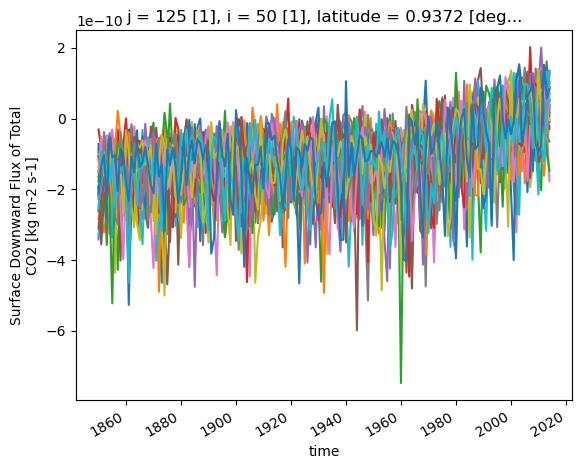

In [16]:
for i in range(31):
    ds.fgco2[i,0,::12,125,50].plot()

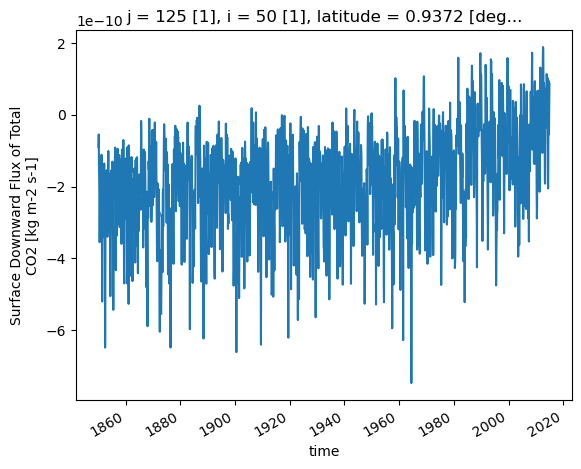

In [14]:
ds.fgco2[0,0,:,125,50].plot()